In [29]:
from icevision.all import *
import re
from importlib import reload

import const
const = reload(const)
import train_detect
train_detect = reload(train_detect)

# For vastai, we'll do everything from the root dir
const.SUBDIR_DATA_DETECT = "./"
const.SUBDIR_MODELS_DETECT = "./"
const.SUBDIR_PREDS_DETECT = "./"

"""
Vastai prep:
- apt-get install gcc
- pip install icevision[all]
"""

'\nVastai prep:\n- apt-get install gcc\n- pip install icevision[all]\n'

In [16]:
# Params
IMAGE_PATH = "png224_7fold_23456"
NUM_FOLDS = 5
IMAGE_SIZE = 128 * 2
MODEL_NAME = "eff_lite0_256"
assert int(re.search(r'\d*$', MODEL_NAME)[0]) == IMAGE_SIZE, "Image size should match model"

BATCH_SIZE = 8

In [17]:
# DATA #

In [18]:
# [(train_ds, valid_ds), ...]
ds_folds = [
    train_detect.get_ds_train_valid(
        box_dir=IMAGE_PATH, 
        image_size=IMAGE_SIZE,
        fold_valid=fold,
    )
    for fold in range(NUM_FOLDS)
]
# train_detect.show_tfmd_imgs(train_ds)

INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (.ipynb_checkpoints): 0


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 613


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold3): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold4): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (.ipynb_checkpoints): 0


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold3): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold4): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 613


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (.ipynb_checkpoints): 0


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 613


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold3): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold4): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (.ipynb_checkpoints): 0


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 613


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold4): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold3): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (.ipynb_checkpoints): 0


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 613


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold3): 614


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold4): 614


In [19]:
# Sanity check fold counts
for train_ds, valid_ds in ds_folds:
    print(len(train_ds), len(valid_ds))

2455 614
2456 613
2455 614
2455 614
2455 614


In [20]:
# [(train_dl, valid_dl), ...]
dl_folds = [
    train_detect.get_dl_train_valid(
        train_ds=train_ds, valid_ds=valid_ds, model_name=MODEL_NAME, 
        batch_size=BATCH_SIZE,
    )
    for train_ds, valid_ds in ds_folds
]

In [22]:
# LEARN #
learn_folds = [
    train_detect.get_learner(
        train_dl=train_dl, valid_dl=valid_dl, model_name=MODEL_NAME
    )
    for train_dl, valid_dl in dl_folds
]

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_lite0-f5f303a9.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_lite0-f5f303a9.pth


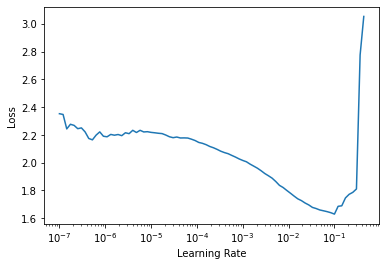

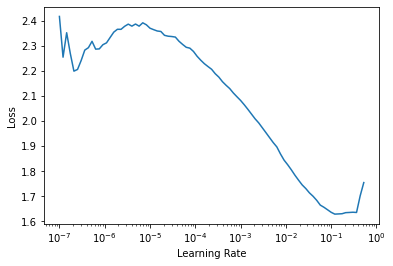

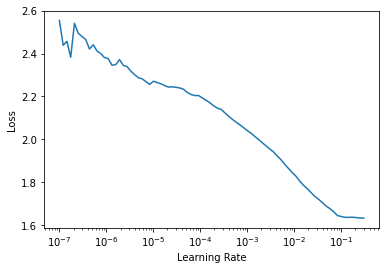

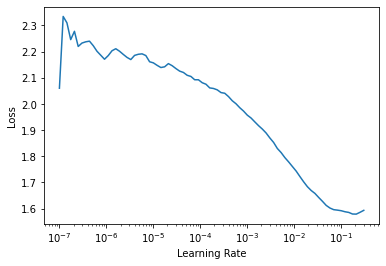

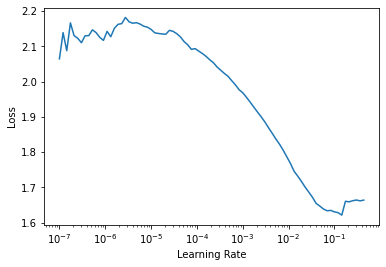

In [23]:
for learn_fold in learn_folds:
    learn_fold.lr_find()

In [24]:
for i, learn in enumerate(learn_folds):
    print(f"Training fold {i}")
    learn.fit_one_cycle(4, 3e-3)
    plt.pause(0.001)

Training fold 0


epoch,train_loss,valid_loss,MapMetric,time
0,0.878988,2.280286,0.151526,00:47
1,0.847976,1.088902,0.360092,00:45
2,0.786476,0.797516,0.488976,00:45
3,0.716412,0.760088,0.543219,00:46


Calculating mAP: 100%|██████████| 11/11 [00:00<00:00, 13.89it/s]


Training fold 1


epoch,train_loss,valid_loss,MapMetric,time
0,0.880983,2.517071,0.168723,00:46
1,0.841205,1.012297,0.263180,00:46
2,0.787359,0.787133,0.520331,00:45
3,0.726993,0.757572,0.540054,00:47


Calculating mAP: 100%|██████████| 11/11 [00:00<00:00, 13.38it/s]


Training fold 2


epoch,train_loss,valid_loss,MapMetric,time
0,0.895104,1.421894,0.259216,00:46
1,0.844045,1.062962,0.396831,00:45
2,0.804361,0.784455,0.485889,00:46
3,0.725142,0.749121,0.550568,00:45


Calculating mAP: 100%|██████████| 11/11 [00:00<00:00, 13.43it/s]


Training fold 3


epoch,train_loss,valid_loss,MapMetric,time
0,0.872232,1.399614,0.354722,00:47
1,0.853290,0.920675,0.317594,00:46
2,0.781164,0.806273,0.471937,00:45
3,0.712902,0.784079,0.499214,00:46


Calculating mAP: 100%|██████████| 11/11 [00:00<00:00, 13.09it/s]


Training fold 4


epoch,train_loss,valid_loss,MapMetric,time
0,0.887853,1.378764,0.249079,00:45
1,0.840972,1.304252,0.199830,00:45
2,0.787776,0.808339,0.484766,00:45
3,0.711087,0.777294,0.516633,00:45


Calculating mAP: 100%|██████████| 11/11 [00:00<00:00, 12.68it/s]


In [25]:
for learn_fold in learn_folds:
    learn_fold.model = learn_fold.model.eval()

In [28]:
train_detect.save_learn_folds(learn_folds=learn_folds, model_name=MODEL_NAME)

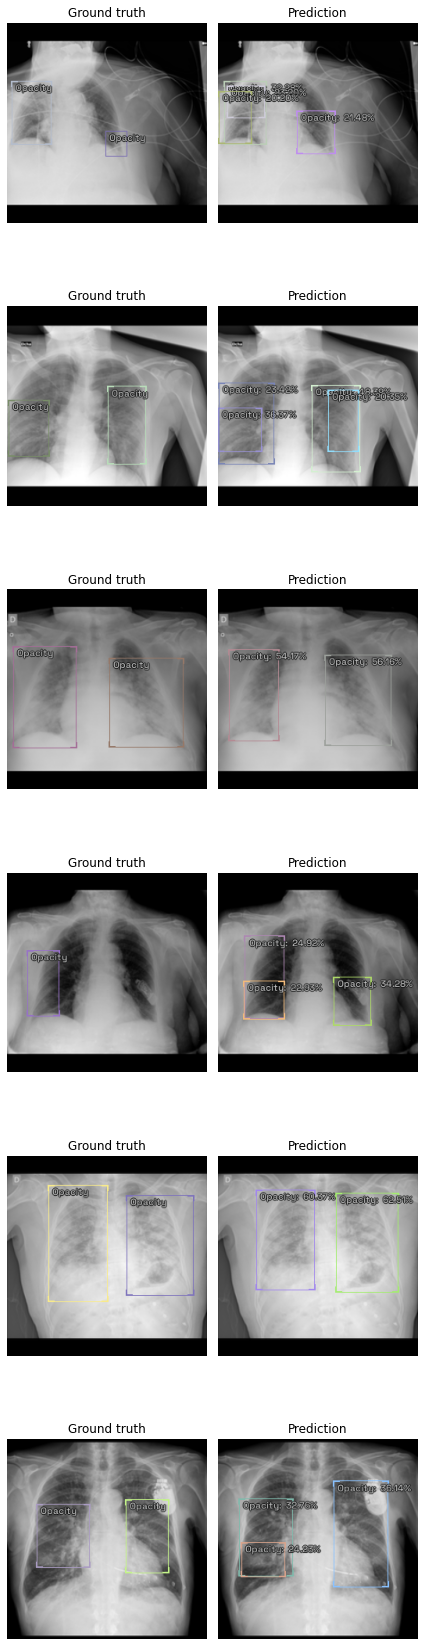

In [23]:
model_type = train_detect.model_name_to_type(MODEL_NAME)
model_type.show_results(learn.model, valid_ds, detection_threshold=0.2)

In [34]:
# Takes a long time. Only do this for heavy-duty error analysis
# model_type.interp.plot_top_losses(learn.model, valid_ds, n_samples=100)

In [24]:
# This stuff is optional. I don't actually need these predictions.
# But it can be a good sanity check

In [25]:
preds = train_detect.predict_and_save(
    box_dir=IMAGE_PATH, image_size=IMAGE_SIZE, model_name=MODEL_NAME, model=learn.model
)

INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (train): 3007


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (valid): 1287


In [26]:
list(preds['train'].values())[0] # Should be a ton of preds

{'scores': array([0.57080394, 0.55049247, 0.14691383, 0.14380167, 0.10526057,
        0.10024755, 0.09977604, 0.09431447, 0.08500114, 0.07772172,
        0.07643197, 0.07132173, 0.06463116, 0.06434689, 0.05832934,
        0.05666716, 0.05661131, 0.0561511 , 0.05280248, 0.04968158,
        0.04802758, 0.04556028, 0.04555743, 0.04493564, 0.04484878,
        0.04389202, 0.04249528, 0.04097582, 0.03887653, 0.03832083,
        0.03804582, 0.03559804, 0.03555591, 0.03442181, 0.03439429,
        0.03403835, 0.03356911, 0.03305256, 0.0318335 , 0.0282654 ,
        0.02824077, 0.0280359 , 0.02786617, 0.02785702, 0.02715657,
        0.0261396 , 0.02610135, 0.02603756, 0.02591621, 0.02564003,
        0.02543326, 0.0251595 , 0.0244546 , 0.02357983, 0.02340357,
        0.02277717, 0.0224099 , 0.0224006 , 0.02082033, 0.02024243,
        0.02015834, 0.02007252, 0.0196241 , 0.0194043 , 0.01930227,
        0.01914908, 0.01897948, 0.01890526, 0.01879833, 0.01826475,
        0.01804318, 0.01803126, 0.0180